# Using BERT to Identify Bill Hardy (Multiclass Classification) [WIP:DRAFT]

## Classification of the Pages

[K-means clustering seems to indicate that some narrators can be inferred from the pages](./1_k-means.ipynb). 

To test this hypothesis, supervised learning will be used to classify the pages.

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with the narrator labels.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def get_narrator(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key
    return None


df = df.astype({"text": "string"})
df["narrator"] = df["page"].apply(lambda x: get_narrator(x))
df

,page,text,narrator
0,1,I sit down alone at the appointed table and ta...,Bill Hardy
1,2,I plunged for the last time. The few remaining...,Oscar Mills
2,3,"At my meeting with Clement yesterday, he had b...",John Walker
3,4,And I really think I would have preferred the ...,Bill Hardy
4,5,I hated my eye for being caught by what didn’t...,May Doncaster
...,...,...,...
95,96,Now I think I will try a cup of what they inso...,Bill Hardy
96,97,To have slept and to wake right up surrounded ...,John Walker
97,98,He stood and looked down at me; but I was not ...,Sir Paul Trinder
98,99,"And she wore a mauve love-knot on her breast, ...",Henry (dog)


Combining the pages and the suggested solution results in a series of numbered pages with a label indicating the narrator.

The data is now labeled.

## Train BERT Model

BERT (Bidirectional Encoder Representations from Transformers) can  be used to classify the pages.

The goal is to train the model on a subset of the pages belonging to different narrators.

Empirically, [BERT<sub>BASE</sub> uncased](https://huggingface.co/bert-base-uncased) has appeared suitable for this purpose.

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT large uncased model
# https://huggingface.co/bert-large-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=8
)

(TODO) Experimenting with different hyperparameters indicates a good balance between accuracy and training performance can be achieved with a learning rate of 2 × 10<sup>-X</sup> and XX learning epochs. 

In [5]:
import torch

# hyperparameters

num_epochs = 20
learning_rate = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The book is sampled for training and testing in the following proportion: **5 pages per narrator**.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df["narrator"] = label_encoder.fit_transform(df["narrator"])


def get_datasets(df):
    # sample 5% of the pages per narrator
    df_sampled = df.groupby("narrator").apply(lambda s: s.sample(5))
    print(df_sampled)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled["narrator"].values,
        test_size=0.2,
    )


train_texts, test_texts, train_labels, test_labels = get_datasets(df)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

             page                                               text  narrator
narrator                                                                      
0        86    87  Of the old bold mate of Henry Morgan. My guest...         0
         62    63  I cannot help, even with this supreme distract...         0
         46    47  Babs now moves across the vision, crowned with...         0
         0      1  I sit down alone at the appointed table and ta...         0
         83    84  I wish she would tell me more. I wish she woul...         0
...           ...                                                ...       ...
7        27    28  I found myself by that one of the windows whic...         7
         97    98  He stood and looked down at me; but I was not ...         7
         8      9  The sound of the bell, as of a boding gnat, ju...         7
         88    89  The ancient had then sat down among the heathe...         7
         11    12  I rubbed my eyes and massaged my 

In [7]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(
                label, dtype=torch.long
            ),
        }


# important: set a large max_len for the pages
train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer, max_len=256),
    batch_size=2,
    shuffle=True,
)
test_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer, max_len=256),
    batch_size=2,
    shuffle=False,
)

In [8]:
from transformers import AdamW
import copy


def train(dataloader):
    model = copy.copy(bert_model)
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model


model = train(train_dataloader)

1/20 — loss: 2.1492
2/20 — loss: 1.9956
3/20 — loss: 1.7714
4/20 — loss: 1.5938
5/20 — loss: 1.2902
6/20 — loss: 1.0401
7/20 — loss: 0.8356
8/20 — loss: 0.6500
9/20 — loss: 0.5063
10/20 — loss: 0.3475
11/20 — loss: 0.2790
12/20 — loss: 0.2011
13/20 — loss: 0.1560
14/20 — loss: 0.1183
15/20 — loss: 0.0984
16/20 — loss: 0.0803
17/20 — loss: 0.0724
18/20 — loss: 0.0593
19/20 — loss: 0.0520
20/20 — loss: 0.0463


## Prediction

In [9]:
from sklearn.metrics import accuracy_score


def eval(model, dataloader):
    model.eval()

    all_labels = []
    all_predictions = []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].cpu().numpy()

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()

        all_labels.extend(labels)
        all_predictions.extend(predicted_labels)

    accuracy = accuracy_score(all_labels, all_predictions)

    return all_predictions, accuracy


predicted_labels, accuracy = eval(model, test_dataloader)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8125


In [10]:
all_dataloader = DataLoader(
    TokenizedData(df["text"], df["narrator"], tokenizer, max_len=256),
    batch_size=2,
    shuffle=True,
)
predicted_labels = eval(model, all_dataloader)

<Figure size 800x600 with 0 Axes>

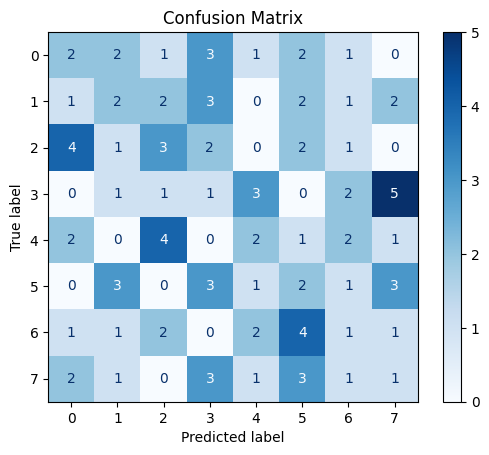

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def generate_confusion_matrix(model, df, predicted_labels):
    true_labels = df["narrator"].values

    class_labels = sorted(df["narrator"].unique())
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format=".4g")
    plt.title("Confusion Matrix")
    plt.show()


generate_confusion_matrix(model, df, predicted_labels[0])